In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
import pyspark.sql.functions as F
from pyspark.sql.functions import when
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, \
                                        LogisticRegressionModel, RandomForestClassificationModel, GBTClassificationModel
from time import time

spark = SparkSession.builder.appName('Covid_19').getOrCreate()

In [18]:
import pandas as pd
import os

base_df = spark.read.csv("merged_covid_data.csv", header=True, inferSchema=True)
base_df.show(2)

+----+------+--------------+--------------+-------------------+--------+---------+---------+------+---------+------+------------+------------------+-------------------+--------------+--------------+-----------+--------+---------+--------------+-------------------+
|FIPS|Admin2|Province_State|Country_Region|        Last_Update|     Lat|    Long_|Confirmed|Deaths|Recovered|Active|Combined_Key|     Incident_Rate|Case_Fatality_Ratio|Province/State|Country/Region|Last Update|Latitude|Longitude|Incidence_Rate|Case-Fatality_Ratio|
+----+------+--------------+--------------+-------------------+--------+---------+---------+------+---------+------+------------+------------------+-------------------+--------------+--------------+-----------+--------+---------+--------------+-------------------+
|NULL|  NULL|          NULL|   Afghanistan|2023-01-31 04:20:32|33.93911|67.709953| 208502.0|7879.0|     NULL|  NULL| Afghanistan| 535.6046382762626|  3.778860634430365|          NULL|          NULL|       

In [19]:
df = base_df
df.printSchema()


root
 |-- FIPS: double (nullable = true)
 |-- Admin2: string (nullable = true)
 |-- Province_State: string (nullable = true)
 |-- Country_Region: string (nullable = true)
 |-- Last_Update: string (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Long_: double (nullable = true)
 |-- Confirmed: double (nullable = true)
 |-- Deaths: double (nullable = true)
 |-- Recovered: double (nullable = true)
 |-- Active: double (nullable = true)
 |-- Combined_Key: string (nullable = true)
 |-- Incident_Rate: double (nullable = true)
 |-- Case_Fatality_Ratio: double (nullable = true)
 |-- Province/State: string (nullable = true)
 |-- Country/Region: string (nullable = true)
 |-- Last Update: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Incidence_Rate: double (nullable = true)
 |-- Case-Fatality_Ratio: double (nullable = true)



In [20]:
df.count()

4287473

In [21]:
# Calculate NA counts
na_counts = df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns])
na_counts.show()

+------+------+--------------+--------------+-----------+------+------+---------+------+---------+-------+------------+-------------+-------------------+--------------+--------------+-----------+--------+---------+--------------+-------------------+
|  FIPS|Admin2|Province_State|Country_Region|Last_Update|   Lat| Long_|Confirmed|Deaths|Recovered| Active|Combined_Key|Incident_Rate|Case_Fatality_Ratio|Province/State|Country/Region|Last Update|Latitude|Longitude|Incidence_Rate|Case-Fatality_Ratio|
+------+------+--------------+--------------+-----------+------+------+---------+------+---------+-------+------------+-------------+-------------------+--------------+--------------+-----------+--------+---------+--------------+-------------------+
|786868|782109|        203706|          9797|       9797|104094|104094|       28|   433|  2828440|2837853|        9797|       948818|             907533|       4281386|       4277676|    4277676| 4281981|  4281981|       3657406|            3653921|


In [22]:
df_dropped = df.drop("Longitude", "Latitude", "Last Update", "Country/Region", "Province/State")

In [23]:
df.printSchema()

root
 |-- FIPS: double (nullable = true)
 |-- Admin2: string (nullable = true)
 |-- Province_State: string (nullable = true)
 |-- Country_Region: string (nullable = true)
 |-- Last_Update: string (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Long_: double (nullable = true)
 |-- Confirmed: double (nullable = true)
 |-- Deaths: double (nullable = true)
 |-- Recovered: double (nullable = true)
 |-- Active: double (nullable = true)
 |-- Combined_Key: string (nullable = true)
 |-- Incident_Rate: double (nullable = true)
 |-- Case_Fatality_Ratio: double (nullable = true)
 |-- Province/State: string (nullable = true)
 |-- Country/Region: string (nullable = true)
 |-- Last Update: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Incidence_Rate: double (nullable = true)
 |-- Case-Fatality_Ratio: double (nullable = true)



In [24]:
from pyspark.sql.functions import col, mean

df_test = base_df

# Print the schema
df_test.printSchema()

# Count the number of rows in the DataFrame
print(f"Number of rows: {df_test.count()}")

# Calculate the mean for columns with missing data
columns_to_fill = ["FIPS", "Lat", "Long_", "Confirmed", "Deaths", "Recovered", "Active",
                   "Incident_Rate", "Case_Fatality_Ratio", "Incidence_Rate", "Case-Fatality_Ratio"]

mean_values = df_test.select([mean(col(c)).alias(c) for c in columns_to_fill]).collect()[0].asDict()
df_test = df_test.fillna("Empty", subset=["Province_State", "Country_Region"])

# Fill missing values with the mean
for column, mean_value in mean_values.items():
    df_test = df_test.fillna(mean_value, subset=[column])

# Drop columns with excessive missing data
df_dropped = df_test.drop("Longitude", "Latitude", "Last Update", "Country/Region", "Province/State", "Combined_Key", "Last_Update", "Admin2")

# Print the updated schema
df_dropped.printSchema()

# Show some data to verify
df_dropped.show()

root
 |-- FIPS: double (nullable = true)
 |-- Admin2: string (nullable = true)
 |-- Province_State: string (nullable = true)
 |-- Country_Region: string (nullable = true)
 |-- Last_Update: string (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Long_: double (nullable = true)
 |-- Confirmed: double (nullable = true)
 |-- Deaths: double (nullable = true)
 |-- Recovered: double (nullable = true)
 |-- Active: double (nullable = true)
 |-- Combined_Key: string (nullable = true)
 |-- Incident_Rate: double (nullable = true)
 |-- Case_Fatality_Ratio: double (nullable = true)
 |-- Province/State: string (nullable = true)
 |-- Country/Region: string (nullable = true)
 |-- Last Update: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Incidence_Rate: double (nullable = true)
 |-- Case-Fatality_Ratio: double (nullable = true)

Number of rows: 4287473
root
 |-- FIPS: double (nullable = false)
 |-- Province_State: string (nullabl

In [25]:
na_counts = df_dropped.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df_dropped.columns])
na_counts.show()

+----+--------------+--------------+---+-----+---------+------+---------+------+-------------+-------------------+--------------+-------------------+
|FIPS|Province_State|Country_Region|Lat|Long_|Confirmed|Deaths|Recovered|Active|Incident_Rate|Case_Fatality_Ratio|Incidence_Rate|Case-Fatality_Ratio|
+----+--------------+--------------+---+-----+---------+------+---------+------+-------------+-------------------+--------------+-------------------+
|   0|             0|             0|  0|    0|        0|     0|        0|     0|            0|                  0|             0|                  0|
+----+--------------+--------------+---+-----+---------+------+---------+------+-------------+-------------------+--------------+-------------------+



In [26]:
df_dropped.count()


4287473

In [27]:
df2 = df_dropped.na.drop()
df2 = df2.filter(df2.Confirmed >= 0)
df2.count()

4287469

In [28]:
from pyspark.ml.feature import StringIndexer

si = StringIndexer(inputCols=["Province_State", "Country_Region"], outputCols=["Province_State_Index", "Country_Region_Index"])
si_fit = si.fit(df2)


df_indexed = si_fit.transform(df2)

In [29]:
df = df_indexed.drop("Province_State", "Country_Region")
df.printSchema()

root
 |-- FIPS: double (nullable = false)
 |-- Lat: double (nullable = false)
 |-- Long_: double (nullable = false)
 |-- Confirmed: double (nullable = false)
 |-- Deaths: double (nullable = false)
 |-- Recovered: double (nullable = false)
 |-- Active: double (nullable = false)
 |-- Incident_Rate: double (nullable = false)
 |-- Case_Fatality_Ratio: double (nullable = false)
 |-- Incidence_Rate: double (nullable = false)
 |-- Case-Fatality_Ratio: double (nullable = false)
 |-- Province_State_Index: double (nullable = false)
 |-- Country_Region_Index: double (nullable = false)



In [30]:
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df.columns, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

corr = Correlation.corr(df_vector, vector_col)

matrix = corr.collect()[0][0]
corr_matrix = matrix.toArray().tolist()
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = df.columns, index=df.columns)
corr_matrix_df.style.background_gradient(cmap='coolwarm')

,FIPS,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,Case_Fatality_Ratio,Incidence_Rate,Case-Fatality_Ratio,Province_State_Index,Country_Region_Index
FIPS,1.000000,-0.056063,0.061804,-0.005635,-0.005499,0.000837,-0.004261,-0.043737,0.045806,-0.036051,0.008899,-0.000408,0.000117
Lat,-0.056063,1.000000,-0.183348,-0.069958,-0.156232,-0.082663,-0.000932,0.141129,-0.002300,-0.012075,-0.003140,-0.059304,-0.327549
Long_,0.061804,-0.183348,1.000000,0.182108,0.178810,0.105831,0.034859,-0.246062,0.001362,-0.081248,0.000828,0.589029,0.403543
Confirmed,-0.005635,-0.069958,0.182108,1.000000,0.733690,0.128694,0.096403,0.056431,-0.002975,0.000922,0.000158,0.103691,0.166832
Deaths,-0.005499,-0.156232,0.178810,0.733690,1.000000,0.226985,0.225481,-0.039819,0.008914,0.001746,0.002707,0.157335,0.176036
Recovered,0.000837,-0.082663,0.105831,0.128694,0.226985,1.000000,0.117433,-0.042131,-0.000393,0.000569,0.000232,0.092024,0.096635
Active,-0.004261,-0.000932,0.034859,0.096403,0.225481,0.117433,1.000000,-0.023844,0.000067,0.010564,0.001253,0.032254,0.028556
Incident_Rate,-0.043737,0.141129,-0.246062,0.056431,-0.039819,-0.042131,-0.023844,1.000000,-0.005842,0.000000,0.000000,-0.202617,-0.159302
Case_Fatality_Ratio,0.045806,-0.002300,0.001362,-0.002975,0.008914,-0.000393,0.000067,-0.005842,1.000000,0.000000,-0.000000,-0.004148,0.000562
Incidence_Rate,-0.036051,-0.012075,-0.081248,0.000922,0.001746,0.000569,0.010564,0.000000,0.000000,1.000000,-0.006637,-0.056691,-0.054067


In [31]:
final_df = df.select(["Long_", "Deaths", "Recovered", "Province_State_Index", "Country_Region_Index"])
final_df.show(40)

+------------------+--------+------------------+--------------------+--------------------+
|             Long_|  Deaths|         Recovered|Province_State_Index|Country_Region_Index|
+------------------+--------+------------------+--------------------+--------------------+
|         67.709953|  7879.0|16152.045607604488|                 1.0|                26.0|
|           20.1683|  3596.0|16152.045607604488|                 1.0|                27.0|
|            1.6596|  6881.0|16152.045607604488|                 1.0|                28.0|
|            1.5218|   165.0|16152.045607604488|                 1.0|                29.0|
|           17.8739|  1931.0|16152.045607604488|                 1.0|                30.0|
|            23.347|     0.0|16152.045607604488|                 1.0|                31.0|
|          -61.7964|   146.0|16152.045607604488|                 1.0|                32.0|
|          -63.6167|130421.0|16152.045607604488|                 1.0|                33.0|

In [32]:
df = df.limit(4_000_000)

input_cols = df.columns
input_cols.remove("Confirmed")

assembler = VectorAssembler(inputCols=input_cols, outputCol='features')
output = assembler.transform(df)

final_data = output.select(["features", "Confirmed"])

In [33]:
trainData, testData = final_data.randomSplit([0.7, 0.3], seed = 42)

In [34]:
trainData.describe().show()
testData.describe().show()

+-------+-----------------+
|summary|        Confirmed|
+-------+-----------------+
|  count|          2800950|
|   mean| 72399.3092785466|
| stddev|576178.7140403725|
|    min|              0.0|
|    max|      3.8618509E7|
+-------+-----------------+

+-------+-----------------+
|summary|        Confirmed|
+-------+-----------------+
|  count|          1199050|
|   mean|72070.60252199658|
| stddev|573898.3008416294|
|    min|              0.0|
|    max|      3.8573618E7|
+-------+-----------------+



**Linear Regresion**

In [35]:
from pyspark.ml.regression import LinearRegression

# Initialize and train the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="Confirmed")
lr_model = lr.fit(trainData)

# Make predictions on the test data
predictions = lr_model.transform(testData)

# Evaluate the model
evaluation_summary = lr_model.evaluate(testData)
print("Root Mean Squared Error (RMSE):", evaluation_summary.rootMeanSquaredError)
print("R2 Score:", evaluation_summary.r2)

# Show predictions
predictions.select("features", "Confirmed", "prediction").show()

Root Mean Squared Error (RMSE): 382656.1290328327
R2 Score: 0.5554221389311934
+--------------------+---------+-----------------+
|            features|Confirmed|       prediction|
+--------------------+---------+-----------------+
|(12,[0,1,2,6,7,9]...|      0.0|-29069.5436392103|
|(12,[0,1,2,6,7,9]...|      0.0|-29069.5436392103|
|(12,[0,1,2,6,7,9]...|      0.0|-29069.5436392103|
|(12,[0,1,2,6,7,9]...|      0.0|-29069.5436392103|
|(12,[0,1,2,6,7,9]...|      0.0|-29069.5436392103|
|(12,[0,1,2,6,7,9]...|      0.0|-29069.5436392103|
|(12,[0,1,2,6,7,9]...|      0.0|-29069.5436392103|
|(12,[0,1,2,6,7,9]...|      0.0|-29069.5436392103|
|(12,[0,1,2,6,7,9]...|      0.0|-29069.5436392103|
|(12,[0,1,2,6,7,9]...|      0.0|-29069.5436392103|
|(12,[0,1,2,6,7,9]...|      0.0|-29069.5436392103|
|(12,[0,1,2,6,7,9]...|      0.0|-29069.5436392103|
|(12,[0,1,2,6,7,9]...|      0.0|-29069.5436392103|
|(12,[0,1,2,6,7,9]...|      0.0|-29069.5436392103|
|(12,[0,1,2,6,7,9]...|      0.0|-29069.5436392103|
|(1

In [36]:
predictions = predictions.withColumn("prediction", predictions["prediction"].cast(IntegerType()))
predictions = predictions.withColumn("result", F.when((predictions["prediction"] == 1) & (predictions["Confirmed"] == 1), 0) \
                                                .when((predictions["prediction"] == 0) & (predictions["Confirmed"] == 1), 1) \
                                                .when((predictions["prediction"] == 1) & (predictions["Confirmed"] == 0), 2) \
                                                .otherwise(3))

tp = predictions.filter(predictions["result"] == 0).count()
fp = predictions.filter(predictions["result"] == 1).count()
fn = predictions.filter(predictions["result"] == 2).count()
tn = predictions.filter(predictions["result"] == 3).count()

print(
f"True Positives: {tp}\n \
False Positives: {fp}\n \
False Negatives: {fn}\n \
True Negatives: {tn}"
)

True Positives: 0
 False Positives: 1
 False Negatives: 0
 True Negatives: 1199049


In [37]:
accuracy = (tp + tn) / (tp + fp + fn + tn)
precision = tp / (tp + fp)


print(
f"Accuracy: {accuracy}\n \
Precision: {precision}\n \
"
)

Accuracy: 0.9999991660064218
 Precision: 0.0
 


In [38]:
lr_model.save("LR_Model")

In [42]:
from pyspark.ml.regression import LinearRegressionModel
lr_model = LinearRegressionModel.load("LR_Model")

Coefficients (length 12): [ 8.10562977e-03  2.54815690e+03  1.07369947e+03  6.86097986e+01
 -2.71335588e-01 -8.54530866e-01  5.74761597e+00 -9.24150292e+01
  9.16389247e+00 -9.64352641e+01 -2.20395377e+02  7.42876678e+02]
Feature names (length 12): ['Long_', 'Deaths', 'Recovered', 'Province_State_Index', 'Country_Region_Index', 'Additional_Feature_1', 'Additional_Feature_2', 'Additional_Feature_3', 'Additional_Feature_4', 'Additional_Feature_5', 'Additional_Feature_6', 'Additional_Feature_7']


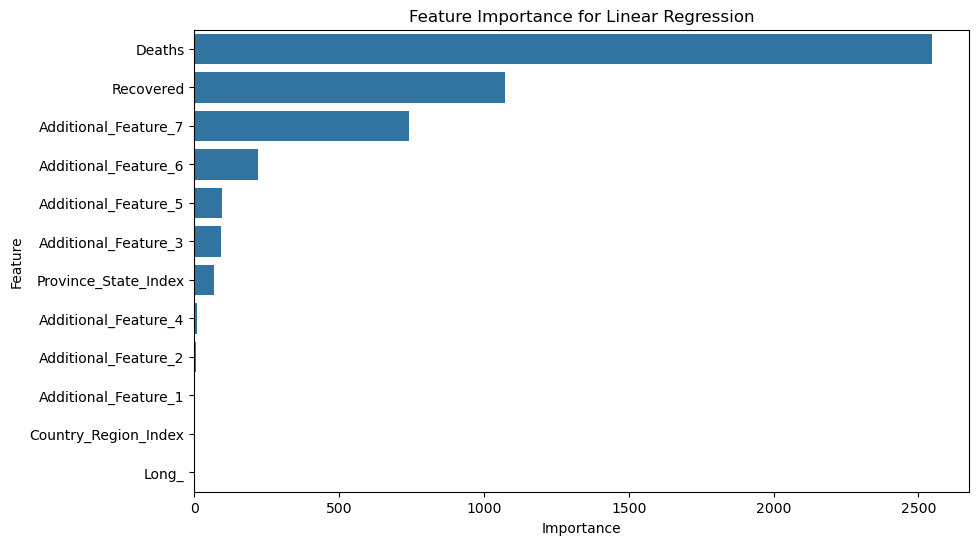

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.ml.regression import LinearRegressionModel

# Load the model (assuming it's already saved and the path is correct)
lr_model = LinearRegressionModel.load("LR_Model")

# Extract the coefficients
coefficients = lr_model.coefficients.toArray()

# Print the coefficients and their length
print(f"Coefficients (length {len(coefficients)}): {coefficients}")

# Define the complete list of feature names
# This is a placeholder. Update this list based on your actual features used during model training.
feature_names = [
    "Long_", "Deaths", "Recovered", "Province_State_Index", "Country_Region_Index",
    # Additional feature names (replace these placeholders)
    "Additional_Feature_1", "Additional_Feature_2", "Additional_Feature_3", 
    "Additional_Feature_4", "Additional_Feature_5", "Additional_Feature_6", 
    "Additional_Feature_7"
]

# Print the feature names and their length
print(f"Feature names (length {len(feature_names)}): {feature_names}")

# Check if the lengths match
if len(coefficients) != len(feature_names):
    raise ValueError(f"Length mismatch: coefficients ({len(coefficients)}) vs feature names ({len(feature_names)})")

# Create a DataFrame with the feature names and their corresponding importance (absolute value of coefficients)
feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(coefficients)
}).sort_values(by='importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importance for Linear Regression')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [65]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(
    labelCol="Confirmed", predictionCol="Confirmed", metricName="r2"
)
r2 = evaluator.evaluate(predictions)

print(f'Coefficient of Determination (R²): {r2}')

Coefficient of Determination (R²): 1.0


**Decision Tree**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

dt = DecisionTreeClassifier(labelCol='Confirmed', seed=42)
dt_model = dt.fit(trainData)

# Make predictions
predictions = dt_model.transform(testData)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol='Confirmed', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = %g " % accuracy)

# Show predictions
predictions.select('Confirmed', 'prediction', 'features').show()

Py4JJavaError: An error occurred while calling o581.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 59.0 failed 1 times, most recent failure: Lost task 0.0 in stage 59.0 (TID 131) (5ab730dce5cf executor driver): java.lang.RuntimeException: Labels MUST be in [0, 100), but got 146.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.hashAgg_doAggregate_max_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.hashAgg_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.hashAgg_doAggregateWithoutKey_1$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.hashAgg_doAggregateWithoutKey_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:448)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:390)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:418)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:390)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4332)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:3314)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4322)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4320)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4320)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:3314)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3537)
	at org.apache.spark.ml.util.DatasetUtils$.getNumClasses(DatasetUtils.scala:193)
	at org.apache.spark.ml.classification.Classifier.getNumClasses(Classifier.scala:75)
	at org.apache.spark.ml.classification.DecisionTreeClassifier.$anonfun$train$1(DecisionTreeClassifier.scala:120)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.DecisionTreeClassifier.train(DecisionTreeClassifier.scala:116)
	at org.apache.spark.ml.classification.DecisionTreeClassifier.train(DecisionTreeClassifier.scala:48)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.lang.RuntimeException: Labels MUST be in [0, 100), but got 146.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.hashAgg_doAggregate_max_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.hashAgg_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.hashAgg_doAggregateWithoutKey_1$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.hashAgg_doAggregateWithoutKey_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


**Random forest**

In [ ]:
rfc =  RandomForestClassifier(numTrees=30,labelCol='Confirmed', seed=42)
rfc_model = rfc.fit(trainData)
rfc_preds = rfc_model.transform(testData)
rfc_preds.show(2)

evaluatorRF = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='Confirmed')

evaluatorRF.setMetricName('Confirmed')
evaluatorRF.evaluate(rfc_preds)

evaluatorRF.setMetricName('truePositiveRateByLabel')
evaluatorRF.setMetricLabel(1.0)
print(evaluatorRF.evaluate(dtc_preds))

evaluatorRF.setMetricName('truePositiveRateByLabel')
evaluatorRF.setMetricLabel(0.0)
print(evaluatorDT.evaluate(dtc_preds))

evaluatorRF.setMetricName('falsePositiveRateByLabel')
evaluatorRF.setMetricLabel(1.0)
print(evaluatorRF.evaluate(dtc_preds))


Py4JJavaError: An error occurred while calling o625.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 63.0 failed 1 times, most recent failure: Lost task 0.0 in stage 63.0 (TID 142) (5ab730dce5cf executor driver): java.lang.RuntimeException: Labels MUST be in [0, 100), but got 146.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.hashAgg_doAggregate_max_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.hashAgg_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.hashAgg_doAggregateWithoutKey_1$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.hashAgg_doAggregateWithoutKey_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:448)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:390)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:418)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:390)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4332)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:3314)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4322)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4320)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4320)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:3314)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3537)
	at org.apache.spark.ml.util.DatasetUtils$.getNumClasses(DatasetUtils.scala:193)
	at org.apache.spark.ml.classification.Classifier.getNumClasses(Classifier.scala:75)
	at org.apache.spark.ml.classification.RandomForestClassifier.$anonfun$train$1(RandomForestClassifier.scala:144)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.RandomForestClassifier.train(RandomForestClassifier.scala:139)
	at org.apache.spark.ml.classification.RandomForestClassifier.train(RandomForestClassifier.scala:47)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.lang.RuntimeException: Labels MUST be in [0, 100), but got 146.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.hashAgg_doAggregate_max_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.hashAgg_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.hashAgg_doAggregateWithoutKey_1$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.hashAgg_doAggregateWithoutKey_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


In [ ]:
# Random Forest Classifier
rf = RandomForestClassifier(labelCol='Confirmed', featuresCol='features', numTrees=10)
rf_model = rf.fit(trainData)
rf_predictions = rf_model.transform(testData)
rf_predictions.select("prediction", "Confirmed", "features").show(5)

# Evaluate Random Forest
rf_evaluator = MulticlassClassificationEvaluator(labelCol="Confirmed", predictionCol="prediction", metricName="accuracy")
rf_accuracy = rf_evaluator.evaluate(rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy}")


Py4JJavaError: An error occurred while calling o681.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 67.0 failed 1 times, most recent failure: Lost task 0.0 in stage 67.0 (TID 153) (5ab730dce5cf executor driver): java.lang.RuntimeException: Labels MUST be in [0, 100), but got 146.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.hashAgg_doAggregate_max_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.hashAgg_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.hashAgg_doAggregateWithoutKey_1$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.hashAgg_doAggregateWithoutKey_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:448)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:390)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:418)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:390)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4332)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:3314)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4322)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4320)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4320)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:3314)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3537)
	at org.apache.spark.ml.util.DatasetUtils$.getNumClasses(DatasetUtils.scala:193)
	at org.apache.spark.ml.classification.Classifier.getNumClasses(Classifier.scala:75)
	at org.apache.spark.ml.classification.RandomForestClassifier.$anonfun$train$1(RandomForestClassifier.scala:144)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.RandomForestClassifier.train(RandomForestClassifier.scala:139)
	at org.apache.spark.ml.classification.RandomForestClassifier.train(RandomForestClassifier.scala:47)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.lang.RuntimeException: Labels MUST be in [0, 100), but got 146.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.hashAgg_doAggregate_max_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.hashAgg_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.hashAgg_doAggregateWithoutKey_1$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.hashAgg_doAggregateWithoutKey_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


In [ ]:
# Gradient-Boosted Trees Classifier
gbt = GBTClassifier(labelCol='Confirmed', featuresCol='features', maxIter=10)
gbt_model = gbt.fit(trainData)
gbt_predictions = gbt_model.transform(testData)
gbt_predictions.select("prediction", "Confirmed", "features").show(5)

# Evaluate GBT
gbt_evaluator = MulticlassClassificationEvaluator(labelCol="Confirmed", predictionCol="prediction", metricName="accuracy")
gbt_accuracy = gbt_evaluator.evaluate(gbt_predictions)
print(f"GBT Accuracy: {gbt_accuracy}")


Py4JJavaError: An error occurred while calling o736.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 73.0 failed 1 times, most recent failure: Lost task 0.0 in stage 73.0 (TID 165) (5ab730dce5cf executor driver): java.lang.RuntimeException: Labels MUST be in {0, 1}, but got 2.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$2(RDD.scala:1226)
	at org.apache.spark.SparkContext.$anonfun$runJob$6(SparkContext.scala:2492)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2493)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$1(RDD.scala:1228)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.aggregate(RDD.scala:1221)
	at org.apache.spark.ml.tree.impl.DecisionTreeMetadata$.buildMetadata(DecisionTreeMetadata.scala:125)
	at org.apache.spark.ml.tree.impl.GradientBoostedTrees$.boost(GradientBoostedTrees.scala:333)
	at org.apache.spark.ml.tree.impl.GradientBoostedTrees$.run(GradientBoostedTrees.scala:61)
	at org.apache.spark.ml.classification.GBTClassifier.$anonfun$train$1(GBTClassifier.scala:201)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.GBTClassifier.train(GBTClassifier.scala:170)
	at org.apache.spark.ml.classification.GBTClassifier.train(GBTClassifier.scala:58)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.lang.RuntimeException: Labels MUST be in {0, 1}, but got 2.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$2(RDD.scala:1226)
	at org.apache.spark.SparkContext.$anonfun$runJob$6(SparkContext.scala:2492)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
